# 7 指令微调

![1719309589135](../image/从零开始构建LLM/1719309589135.png)

In [1]:
import os
import time
import json
from functools import partial

import urllib
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
from transformers import GPT2Model

from scripts.GPTmodel import GPTModel
from scripts.scripts import load_weights_into_gpt, calc_loss_loader, plot_losses, generate, text_to_token_ids, token_ids_to_text, train_model_simple

## 7.1 指令微调介绍

功能概览

![1719309666974](../image/从零开始构建LLM/1719309666974.png)

流程

![1719309789448](../image/从零开始构建LLM/1719309789448.png)


## 7.2 准备数据

In [2]:
def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data


file_path = "../data/instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
# preview data
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

LLM的输入由多种形式，下图展示了两种形式：Alpaca和Phi-3，本文使用Alpaca形式进行训练。<br/>
训练格式应当如下图所示：

![1719373091773](../image/从零开始构建LLM/1719373091773.png)

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [7]:
# split data
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(">> Training set length:", len(train_data))
print(">> Validation set length:", len(val_data))
print(">> Test set length:", len(test_data))

>> Training set length: 935
>> Validation set length: 55
>> Test set length: 110


## 7.3 数据封装

![1719380932620](../image/从零开始构建LLM/1719380932620.png)

![1719381496083](../image/从零开始构建LLM/1719381496083.png)

In [8]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        # Pre-tokenize texts
        for entry in data:
            instruction_plus_input = self.format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def format_input(self, entry):
        instruction_text = (
            f"Below is an instruction that describes a task. "
            f"Write a response that appropriately completes the request."
            f"\n\n### Instruction:\n{entry['instruction']}"
        )

        input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
        return instruction_text + input_text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]

In [9]:
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(entry)+1 for entry in batch)

    inputs_lst, targets_lst = [], []

    for entry in batch:
        new_entry = entry.copy()
        new_entry += [pad_token_id]

        padded = new_entry + [pad_token_id] * (batch_max_length - len(new_entry))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


## 7.4 创建dataloader

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [14]:
num_workers = 0
batch_size = 8

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=customized_collate_fn,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=customized_collate_fn,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=customized_collate_fn,
    num_workers=num_workers
)

In [15]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 63]) torch.

## 7.5 加载预训练模型

In [16]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model = GPTModel(BASE_CONFIG)
model

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_fe

In [17]:
gpt_model = GPT2Model.from_pretrained("../models/gpt2-medium")
gpt_model

GPT2Model(
  (wte): Embedding(50257, 1024)
  (wpe): Embedding(1024, 1024)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x GPT2Block(
      (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [18]:
load_weights_into_gpt(model, gpt_model)
model.eval()

d:\Desktop\Build_A_Large_Language_Model\code\scripts\scripts.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  left.copy_(torch.tensor(right))


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_fe

In [19]:
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [20]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [21]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6 微调指令大模型

In [22]:
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8324549198150635
Validation loss: 3.7619208812713625


In [23]:
start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

>> Epoch 1, step  00000: train loss 2.5239, val loss 2.5420
>> Epoch 1, step  00005: train loss 1.0049, val loss 1.0680
>> Epoch 1, step  00010: train loss 0.7746, val loss 0.9473
>> Epoch 1, step  00015: train loss 0.8621, val loss 0.9093
>> Epoch 1, step  00020: train loss 0.8994, val loss 0.8823
>> Epoch 1, step  00025: train loss 0.7246, val loss 0.8580
>> Epoch 1, step  00030: train loss 0.7472, val loss 0.8450
>> Epoch 1, step  00035: train loss 0.6855, val loss 0.8197
>> Epoch 1, step  00040: train loss 0.7196, val loss 0.7955
>> Epoch 1, step  00045: train loss 0.6104, val loss 0.7674
>> Epoch 1, step  00050: train loss 0.5730, val loss 0.7627
>> Epoch 1, step  00055: train loss 0.5825, val loss 0.7548
>> Epoch 1, step  00060: train loss 0.5951, val loss 0.7522
>> Epoch 1, step  00065: train loss 0.5697, val loss 0.7430
>> Epoch 1, step  00070: train loss 0.5476, val loss 0.7388
>> Epoch 1, step  00075: train loss 0.4907, val loss 0.7310
>> Epoch 1, step  00080: train loss 0.55

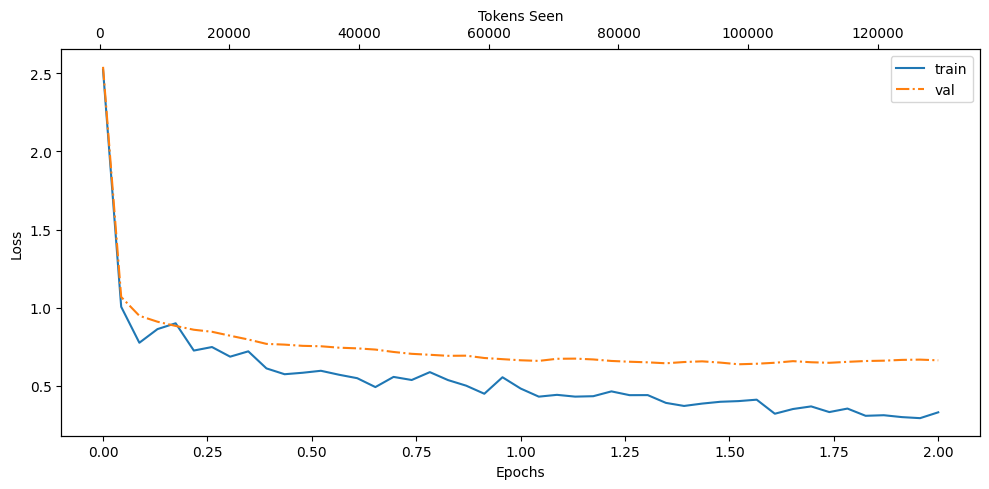

In [24]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 提取并保存结果

In [25]:
for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the capital of Germany?


The capital of Germany is Berlin.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the capital of Spain?


The capital of Spain is Madrid.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the capital of the United Kingdom?


The capital of the United Kingdom is London.<|endoftext|>The following is an instruction 

In [27]:
torch.save(model.state_dict(), "../models/custom/instruction-model.pth")

## 7.8 评估微调后的 LLM


使用Ollama进行评估